# Copy Task Plots

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from glob import glob
import json
import os
import sys
import sys
%matplotlib inline

## Load training history

To generate the models and training history used in this notebook, run the following commands:

```
mkdir ./notebooks/copy
./train.py --seed 1 --task copy --checkpoint-interval 500 --checkpoint-path ./notebooks/copy
./train.py --seed 10 --task copy --checkpoint-interval 500 --checkpoint-path ./notebooks/copy
./train.py --seed 100 --task copy --checkpoint-interval 500 --checkpoint-path ./notebooks/copy
./train.py --seed 1000 --task copy --checkpoint-interval 500 --checkpoint-path ./notebooks/copy
```

In [125]:
batch_num = 5000
files = glob("./InterLeave-task-*-{}.json".format(batch_num))
files

['./InterLeave-task-1000-batch-5000.json']

In [126]:
# Read the metrics from the .json files
history = [json.loads(open(fname, "rt").read()) for fname in files]
training = np.array([(x['cost'], x['loss'], x['seq_lengths']) for x in history])
print("Training history (seed x metric x sequence) =", training.shape)


Training history (seed x metric x sequence) = (1, 3, 5000)


In [127]:
# Average every dv values across each (seed, metric)
dv = 1000
training = training.reshape(len(files), 3, -1, dv).mean(axis=3)
print(training.shape)

(1, 3, 5)


In [128]:
# Average the seeds
training_mean = training.mean(axis=0)
training_std = training.std(axis=0)
print(training_mean.shape)
print(training_std.shape)

(3, 5)
(3, 5)


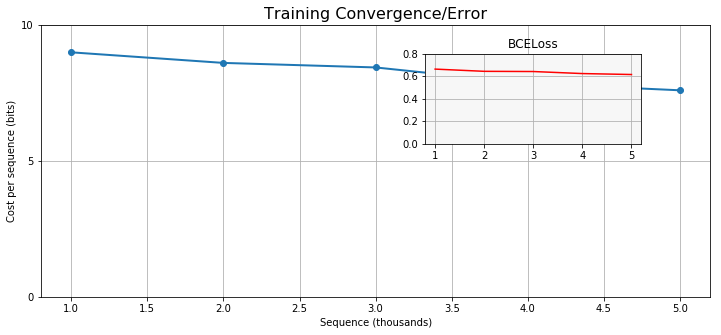

In [129]:
fig = plt.figure(figsize=(12, 5))

# X axis is normalized to thousands
x = np.arange(dv / 1000, (batch_num / 1000) + (dv / 1000), dv / 1000)

# Plot the cost
# plt.plot(x, training_mean[0], 'o-', linewidth=2, label='Cost')
plt.errorbar(x, training_mean[0], yerr=training_std[0], fmt='o-', elinewidth=2, linewidth=2, label='Cost')
plt.grid()
plt.yticks(np.arange(0, training_mean[0][0]+5, 5))
plt.ylabel('Cost per sequence (bits)')
plt.xlabel('Sequence (thousands)')
plt.title('Training Convergence/Error', fontsize=16)

ax = plt.axes([.57, .55, .25, .25], facecolor=(0.97, 0.97, 0.97))
plt.title("BCELoss")
plt.plot(x, training_mean[1], 'r-', label='BCE Loss')
plt.yticks(np.arange(0, training_mean[1][0]+0.2, 0.2))
plt.grid()

plt.show()

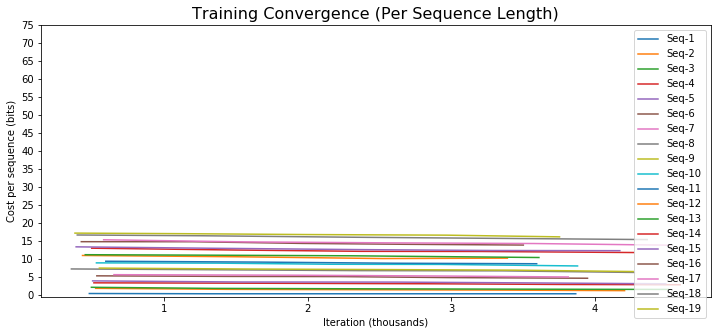

In [130]:
loss = history[0]['loss']
cost = history[0]['cost']
seq_lengths = history[0]['seq_lengths']

unique_sls = set(seq_lengths)
all_metric = list(zip(range(1, batch_num+1), seq_lengths, loss, cost))

fig = plt.figure(figsize=(12, 5))
plt.ylabel('Cost per sequence (bits)')
plt.xlabel('Iteration (thousands)')
plt.title('Training Convergence (Per Sequence Length)', fontsize=16)

for sl in unique_sls:
    sl_metrics = [i for i in all_metric if i[1] == sl]

    x = [i[0] for i in sl_metrics]
    y = [i[3] for i in sl_metrics]
    
    num_pts = len(x) // 50
    total_pts = num_pts * 50
    
    x_mean = [i.mean()/1000 for i in np.split(np.array(x)[:total_pts], num_pts)]
    y_mean = [i.mean() for i in np.split(np.array(y)[:total_pts], num_pts)]
    
    plt.plot(x_mean, y_mean, label='Seq-{}'.format(sl))

plt.yticks(np.arange(0, 80, 5))
plt.legend(loc=0)
plt.show()